# Projeto 22: Previsão do preço de ações com Redes Neurais Recorrentes - Múltiplos Saídas

In [1]:
!pip install torch==1.4.0

## Etapa 1: Importação das bibliotecas

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
torch.manual_seed(123)

## Base de dados

In [4]:
df_train = pd.read_csv('/content/petr4_treinamento.csv')
df_test = pd.read_csv('/content/petr4_teste.csv')

In [5]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [6]:
df_train.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1240,2017-12-25,15.75,15.750000,15.75,15.750000,15.718563,0.0
1241,2017-12-26,15.75,15.990000,15.69,15.970000,15.938125,22173100.0
1242,2017-12-27,15.99,16.139999,15.98,16.049999,16.017963,23552200.0
1243,2017-12-28,16.10,16.129999,16.00,16.100000,16.067865,19011500.0
1244,2017-12-29,16.10,16.100000,16.10,16.100000,16.067865,0.0


In [7]:
df_train.isnull().sum()

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

In [8]:
df_train.dropna(inplace=True)
df_train.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
df_grp = df_train.copy()
df_grp['Date'] = df_grp['Date'].apply(lambda x: x[:-3])
df_grp = df_grp.groupby('Date').mean().reset_index()
df_grp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01,19.698095,19.874762,19.384286,19.573810,17.979544,2.635205e+07
1,2013-02,17.565000,17.768889,17.337778,17.537778,16.109345,3.152355e+07
2,2013-03,18.376842,18.738421,18.130526,18.423158,16.922611,3.226189e+07
3,2013-04,18.240476,18.583810,17.998572,18.308095,16.833584,3.010713e+07
4,2013-05,19.997619,20.257143,19.766190,20.008095,18.726952,2.737860e+07


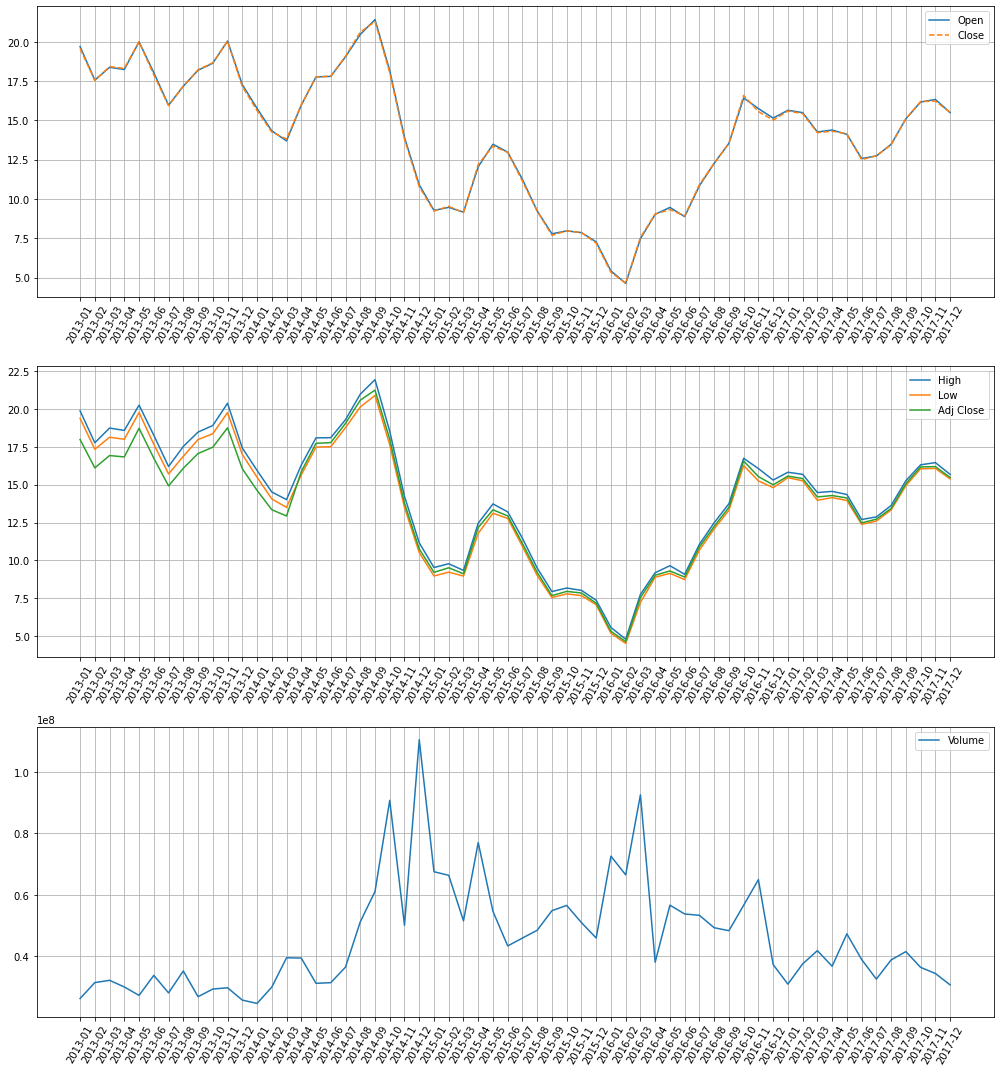

In [10]:
fig, ax = plt.subplots(3,1, figsize=(14,15))
ax[0].plot(df_grp['Date'], df_grp['Open'], label='Open')
ax[0].plot(df_grp['Date'], df_grp['Close'], label='Close', linestyle='--')
ax[0].xaxis.set_tick_params(rotation=60)
ax[0].grid()
ax[0].legend()

ax[1].plot(df_grp['Date'], df_grp['High'], label='High')
ax[1].plot(df_grp['Date'], df_grp['Low'], label='Low')
ax[1].plot(df_grp['Date'], df_grp['Adj Close'], label='Adj Close')
ax[1].xaxis.set_tick_params(rotation=60)
ax[1].grid()
ax[1].legend()

ax[2].plot(df_grp['Date'], df_grp['Volume'], label='Volume')
ax[2].xaxis.set_tick_params(rotation=60)
ax[2].grid()
ax[2].legend()

plt.tight_layout();

In [11]:
X_train = df_train.iloc[:,1:3].values
X_train

array([[19.99    , 20.209999],
       [19.809999, 20.4     ],
       [20.33    , 20.620001],
       ...,
       [15.99    , 16.139999],
       [16.1     , 16.129999],
       [16.1     , 16.1     ]])

In [12]:
train_scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = train_scaler.fit_transform(X_train)
X_scaled

array([[0.76501938, 0.77266112],
       [0.7562984 , 0.78187106],
       [0.78149225, 0.79253519],
       ...,
       [0.57122093, 0.57537562],
       [0.57655039, 0.57489089],
       [0.57655039, 0.57343674]])

In [13]:
X_scaled.shape

(1242, 2)

In [14]:
X, y = [], []
for i in range(90, X_scaled.shape[0]):
  X.append(X_scaled[i-90:i, 0])
  y.append(X_scaled[i, 0:2])
X, y = np.array(X), np.array(y)

In [15]:
X[0]

array([0.76501938, 0.7562984 , 0.78149225, 0.78875969, 0.77083338,
       0.74806197, 0.75436047, 0.75823643, 0.76598837, 0.76598837,
       0.76017437, 0.75872098, 0.75581391, 0.74467054, 0.7374031 ,
       0.7374031 , 0.73498067, 0.75242248, 0.73401163, 0.71656977,
       0.68120155, 0.67538755, 0.67635659, 0.63372098, 0.66521318,
       0.65649225, 0.64680228, 0.66618222, 0.65843028, 0.64970935,
       0.65116274, 0.66424419, 0.67344961, 0.64292631, 0.64486434,
       0.62257747, 0.60949617, 0.60998067, 0.60852713, 0.59593023,
       0.61143411, 0.60222863, 0.64922481, 0.68362398, 0.70687989,
       0.68265509, 0.70978682, 0.70784879, 0.71608527, 0.73643411,
       0.7122093 , 0.7122093 , 0.7194767 , 0.70348832, 0.69525189,
       0.70397287, 0.70397287, 0.69767442, 0.68168605, 0.68168605,
       0.65310078, 0.66618222, 0.64825581, 0.66182175, 0.64341085,
       0.67877902, 0.69137592, 0.66569772, 0.65406982, 0.64292631,
       0.64147292, 0.63565891, 0.67587209, 0.68653106, 0.70300

In [16]:
y[0]

array([0.76114341, 0.76490543])

In [17]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [18]:
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

## Etapa 3: Construção da rede neural recorrente

In [19]:
class Reg_LSTM(nn.Module):
  def __init__(self):
    super(Reg_LSTM, self).__init__()

    self.lstm1 = nn.LSTM(input_size=1, hidden_size=100, batch_first=True)
    self.lstm2 = nn.LSTM(100, 50, batch_first=True)
    self.lstm3 = nn.LSTM(50,50, dropout=0.3, num_layers=2, batch_first=True)
    self.dropout = nn.Dropout(p=0.3)
    self.linear = nn.Linear(in_features=50, out_features=2)

  def forward(self, X):
    # X = (batch_size, timesteps) => (timesteps, batch_size, dimensions)
    X = X.unsqueeze(2)
    X, _ = self.lstm1(X)
    X = self.dropout(X)
    X, _ = self.lstm2(X)
    X = self.dropout(X)
    X, _ = self.lstm3(X)

    X = X[:, -1, :]
    X = self.dropout(X)
    X = self.linear(X)

    return X

In [20]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [21]:
reg = Reg_LSTM()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(reg.parameters(), lr=1e-3, alpha=0.9)
reg.to(device)

Reg_LSTM(
  (lstm1): LSTM(1, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (lstm3): LSTM(50, 50, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

## Etapa 4: Treinamento do modelo

In [22]:
# Variáveis para o callback
ES_MIN_DELTA = 1e-10
ES_PATIENCE = 10
RLR_FACTOR = 0.2
RLR_PATIENCE = 5

# Inicializando o custo inicial para usar o callback
min_loss = np.inf

In [23]:
arr_loss, arr_mae = [], []
for epoch in range(200):

  run_loss = 0.
  run_mae = 0.

  for i, data in enumerate(loader):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = reg(inputs)

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    run_loss += loss.item()
    mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(),
                              outputs.detach().cpu().numpy().flatten())
    
    run_mae += mae

    print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: custo {:03.5f} | MAE {:03.5f}' \
          .format(epoch+1, i+1, len(loader), loss, mae), end='\r')
    
  run_loss /= len(loader)
  run_mae /= len(loader)
  arr_loss.append(run_loss)
  arr_mae.append(run_mae)
  print('ÉPOCA {:3d} FINALIZADA: custo {:03.6f} | MAE {:03.6f}      ' \
        .format(epoch+1, run_loss, run_mae))


  # SALVAR O MODELO
  if run_loss < min_loss:
    print('** Custo reduzido de {:03.6f} >>> {:03.6f} ... SALVANDO CHECKPOINT\n' \
          .format(min_loss, run_loss))
    torch.save(reg.state_dict(), 'checkpoint.pth')
    min_loss = run_loss
    es_patience = 0
    rlr_patience = 0

  else:
    print('**Custo não reduziu, não salva checkpoint\n')
    # OS DEMAIS PARÂMETROS SÓ SERÃO CONSIDERADOS SE O CUSTO NÃO TIVER
    # PARADA ANTECIPADA
    if run_loss - min_loss >= ES_MIN_DELTA:
      es_patience += 1

      if es_patience == ES_PATIENCE:
        print('--Critério de parada antecipada alcaçado, parando o treinamento.')
        break

    # REDUZIR A TAXA DE APRENDIZAGEM
    rlr_patience += 1
    if rlr_patience == RLR_PATIENCE:
      print('--Critério de redução de taxa de aprendizagem alcançado, reduzindo LR.')
      for param_group in optimizer.param_groups:
        param_group['lr'] *= RLR_FACTOR
      
      rlr_patience = 0

ÉPOCA   1 FINALIZADA: custo 0.061374 | MAE 0.198876      
** Custo reduzido de inf >>> 0.061374 ... SALVANDO CHECKPOINT

ÉPOCA   2 FINALIZADA: custo 0.026891 | MAE 0.132045      
** Custo reduzido de 0.061374 >>> 0.026891 ... SALVANDO CHECKPOINT

ÉPOCA   3 FINALIZADA: custo 0.021020 | MAE 0.112537      
** Custo reduzido de 0.026891 >>> 0.021020 ... SALVANDO CHECKPOINT

ÉPOCA   4 FINALIZADA: custo 0.016192 | MAE 0.098352      
** Custo reduzido de 0.021020 >>> 0.016192 ... SALVANDO CHECKPOINT

ÉPOCA   5 FINALIZADA: custo 0.013272 | MAE 0.090876      
** Custo reduzido de 0.016192 >>> 0.013272 ... SALVANDO CHECKPOINT

ÉPOCA   6 FINALIZADA: custo 0.011576 | MAE 0.084234      
** Custo reduzido de 0.013272 >>> 0.011576 ... SALVANDO CHECKPOINT

ÉPOCA   7 FINALIZADA: custo 0.010952 | MAE 0.081829      
** Custo reduzido de 0.011576 >>> 0.010952 ... SALVANDO CHECKPOINT

ÉPOCA   8 FINALIZADA: custo 0.009138 | MAE 0.073554      
** Custo reduzido de 0.010952 >>> 0.009138 ... SALVANDO CHECKPOIN

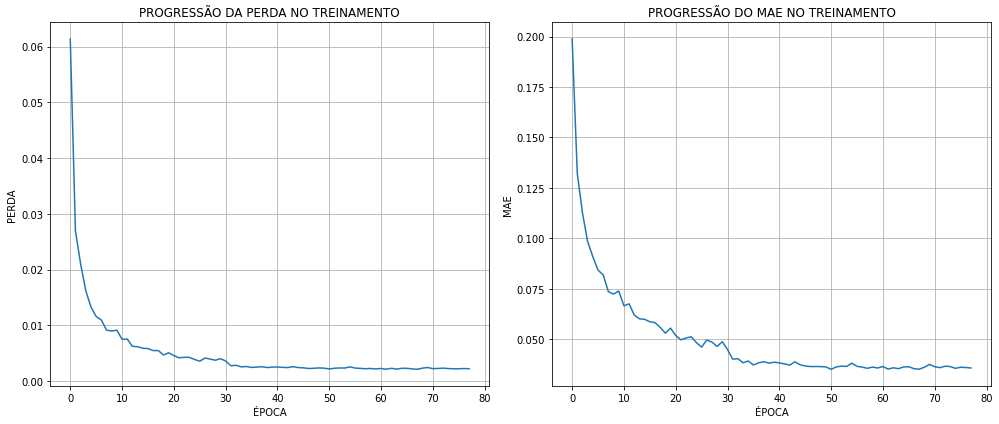

In [24]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax[0].plot(arr_loss, label='Perda')
ax[0].set(xlabel='ÉPOCA', ylabel='PERDA', title='PROGRESSÃO DA PERDA NO TREINAMENTO')
ax[0].grid()

ax[1].plot(arr_mae, label='MAE')
ax[1].set(xlabel='ÉPOCA', ylabel='MAE', title='PROGRESSÃO DO MAE NO TREINAMENTO')
ax[1].grid()

plt.tight_layout();

## Etapa 5: Processamento da base de teste

In [25]:
df_completa = pd.concat((df_train['Open'], df_test['Open']), axis=0)
df_completa.head()

0    19.990000
1    19.809999
2    20.330000
3    20.480000
4    20.110001
Name: Open, dtype: float64

In [26]:
entradas = df_completa[len(df_completa) - len(df_test) - 90:].values
entradas = entradas.reshape(-1,1)

In [27]:
scaler = MinMaxScaler().fit(X_train[:, 0:1])
entradas = scaler.transform(entradas)

In [28]:
X_test = []
for i in range(90, 112):
  X_test.append(entradas[i-90:i, 0])
X_test = np.array(X_test)

In [29]:
X_test = torch.tensor(X_test, device = device, dtype=torch.float32)

## Etapa 6: Previsões

In [30]:
reg.eval()
previsoes = reg(X_test)
previsoes = previsoes.detach().cpu().numpy()
previsoes = scaler.inverse_transform(previsoes)
previsoes

array([[16.022535, 16.199236],
       [16.098682, 16.27773 ],
       [16.215776, 16.394032],
       [16.418667, 16.591942],
       [16.621235, 16.792322],
       [16.740946, 16.915886],
       [16.825441, 17.004684],
       [16.878769, 17.062492],
       [16.889542, 17.078419],
       [16.90248 , 17.094233],
       [16.99712 , 17.186049],
       [17.153511, 17.33777 ],
       [17.41944 , 17.595274],
       [17.808615, 17.973532],
       [18.163769, 18.325434],
       [18.330013, 18.500824],
       [18.33748 , 18.522108],
       [18.290844, 18.486197],
       [18.482777, 18.671225],
       [18.943699, 19.114609],
       [19.422789, 19.584137],
       [19.695063, 19.862755]], dtype=float32)

In [31]:
previsoes.mean(axis=0)

array([17.48451 , 17.662312], dtype=float32)

In [32]:
df_test['Open'].mean()

17.874545636363635

In [33]:
df_test['High'].mean()

18.148181636363635

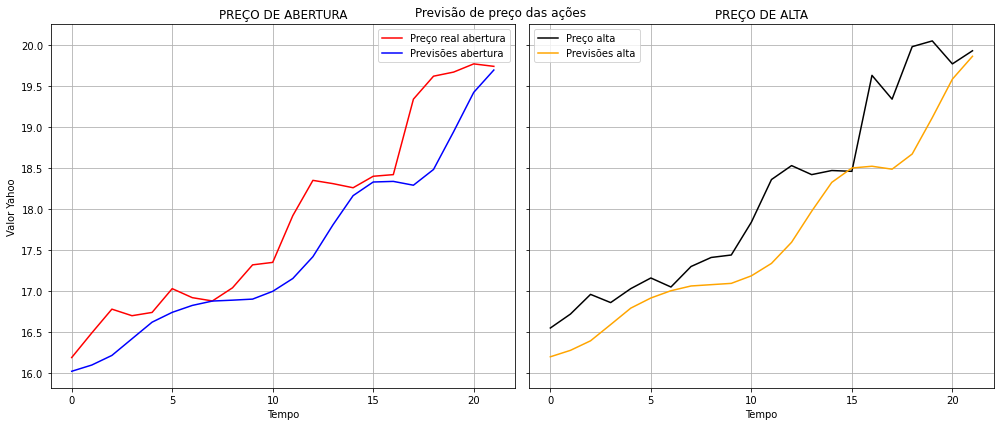

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(14,6), sharey=True)
fig.suptitle('Previsão de preço das ações')

ax[0].plot(df_test['Open'], color='red', label='Preço real abertura')
ax[0].plot(previsoes[:, 0], color = 'blue', label='Previsões abertura')
ax[0].set(xlabel='Tempo', title='PREÇO DE ABERTURA', ylabel='Valor Yahoo')
ax[0].legend()
ax[0].grid()

ax[1].plot(df_test['High'], color='black', label='Preço alta')
ax[1].plot(previsoes[:,1], color = 'orange', label='Previsões alta')
ax[1].set(xlabel='Tempo', title='PREÇO DE ALTA')
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()